1. Import numpy, matplotlib, and scipy.integrate (solve_ivp, quad)
2. Define parameters: omega_0, I = 1 (moment of inertia)
3. Define the pendulum ODE:
      theta' = angular velocity
      ang_vel' = - omega_0^2 * sin(theta)
4. Define event function to detect either:
      - Peak (theta velocity crosses zero going downward)
      - Revolution (theta crosses 2π)
5. Loop over a range of initial angular velocities (ang_vel_0)
      For each:
          - Solve ODE with solve_ivp for a long enough time
          - Use event detection to find the first revolution time (Trev)
          - Use peak-to-peak time to find the period (T)
6. Integral method:
      - For each ang_vel_0, compute corresponding energy
      - From energy, find turning points and set up integrand
      - Use quad to integrate period formula
      - For Trev, integrate over full 2π revolution
7. Plot T and Trev vs ang_vel_0 for both methods on the same graph


/tmp/ipython-input-3378714455.py:90: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Trev_int_val, _ = quad(period_integrand, 0, 2*np.pi, args=(E,))


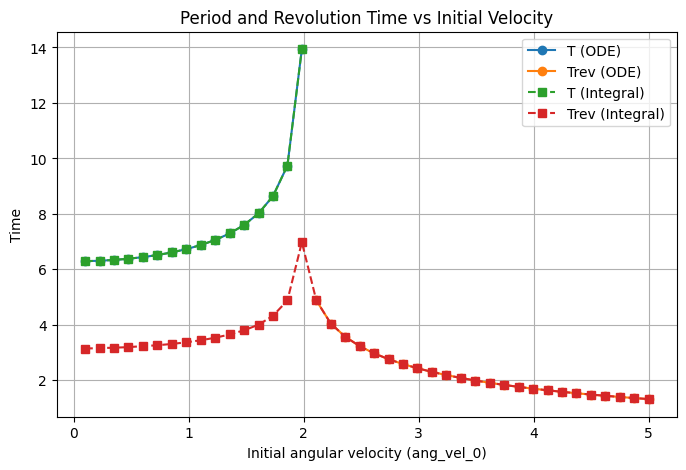

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

# Parameters
omega_0 = 1.0
I = 1.0

# Pendulum ODE
def rigid_pendulum_ode(t, y, omega_0=omega_0):
    theta, ang_vel = y
    return [ang_vel, -omega_0**2 * np.sin(theta)]

# Event: peak (when angular velocity crosses zero downward)
def peak_event(t, y, omega_0=omega_0):
    return y[1]
peak_event.direction = -1
peak_event.terminal = False

# Event: revolution (theta reaches 2π)
def revolution_event(t, y, omega_0=omega_0):
    return y[0] - 2*np.pi
revolution_event.direction = 1
revolution_event.terminal = True

# Range of initial angular velocities
ang_vel_0_list = np.linspace(0.1, 5, 40)

T_list_ode = []
Trev_list_ode = []

# ODE method
for ang_vel_0 in ang_vel_0_list:
    y0 = [0.0, ang_vel_0]
    t_span = [0, 50]
    sol = solve_ivp(
        rigid_pendulum_ode, t_span, y0,
        args=(omega_0,),
        events=[peak_event, revolution_event],
        max_step=0.01, dense_output=True
    )

    # Period from peaks
    if len(sol.t_events[0]) >= 2:
        T_val = sol.t_events[0][1] - sol.t_events[0][0]
    else:
        T_val = np.nan

    # Revolution time
    if len(sol.t_events[1]) >= 1:
        Trev_val = sol.t_events[1][0]
    else:
        Trev_val = np.nan

    T_list_ode.append(T_val)
    Trev_list_ode.append(Trev_val)

T_list_ode = np.array(T_list_ode)
Trev_list_ode = np.array(Trev_list_ode)

# Integral method
def period_integrand(theta, E, omega_0=omega_0, I=I):
    inside = 2*(E/I - omega_0**2*(1 - np.cos(theta)))
    if inside <= 0:
        return 0  # avoid domain error
    return 1.0 / np.sqrt(inside)

T_list_int = []
Trev_list_int = []

for ang_vel_0 in ang_vel_0_list:
    E = 0.5 * ang_vel_0**2

    val = 1 - E/(omega_0**2)
    # For energies above the potential maximum (E > 2), it's a revolving motion.
    if val < -1:
        theta_max = np.pi
    else:
        theta_max = np.arccos(val)

    # Period integral (only valid for oscillatory motion)
    if E < 2*omega_0**2:
        T_int_val, _ = quad(period_integrand, 0, theta_max, args=(E,))
        T_int_val *= 4
    else:
        T_int_val = np.nan

    # Revolution time integral
    try:
        Trev_int_val, _ = quad(period_integrand, 0, 2*np.pi, args=(E,))
    except Exception:
        Trev_int_val = np.nan

    T_list_int.append(T_int_val)
    Trev_list_int.append(Trev_int_val)

T_list_int = np.array(T_list_int)
Trev_list_int = np.array(Trev_list_int)

# Plot
plt.figure(figsize=(8,5))
plt.plot(ang_vel_0_list, T_list_ode, 'o-', label='T (ODE)')
plt.plot(ang_vel_0_list, Trev_list_ode, 'o-', label='Trev (ODE)')
plt.plot(ang_vel_0_list, T_list_int, 's--', label='T (Integral)')
plt.plot(ang_vel_0_list, Trev_list_int, 's--', label='Trev (Integral)')
plt.xlabel('Initial angular velocity (ang_vel_0)')
plt.ylabel('Time')
plt.title('Period and Revolution Time vs Initial Velocity')
plt.legend()
plt.grid(True)
plt.show()
